# Saving_Branch Version

In [1]:
import numpy as np
from tensorflow import keras
from keras.layers import Input, Dense, Lambda, BatchNormalization
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.models import save_model
from scipy.special import rel_entr


In [2]:
train_data = pd.read_csv("../data/interim/split/sorted_train_data_mm.csv")
test_data = pd.read_csv("../data/interim/split/sorted_test_data_mm.csv")
val_data = pd.read_csv("../data/interim/split/sorted_val_data_mm.csv")

In [3]:
train_data_array = train_data.values
test_data_array = test_data.values
val_data_array = val_data.values

In [4]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # epsilon = gumbel_sample((batch, dim))
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [5]:
latent_dim = 32
encoder_inputs = Input(shape=(31), name="input_layer")

n_x1 = 256
x = Dense(n_x1, activation="relu", name="h1")(encoder_inputs)
x = BatchNormalization(name="batch1")(x)
x = Dense(n_x1, activation="relu", name="h2")(x)

# Split x3 into two halves
half_size = n_x1 // 2
x1_first_half = Lambda(lambda x: x[:, :half_size], name="select_z_mean")(x)
x1_second_half = Lambda(lambda x: x[:, half_size:], name="select_z_var")(x)

z_mean = Dense(latent_dim, name="z_mean")(x1_first_half)
z_log_var = Dense(latent_dim, name="z_log_var")(x1_second_half)
z = Sampling(name="Sampling")([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 31)]         0           []                               
                                                                                                  
 h1 (Dense)                     (None, 256)          8192        ['input_layer[0][0]']            
                                                                                                  
 batch1 (BatchNormalization)    (None, 256)          1024        ['h1[0][0]']                     
                                                                                                  
 h2 (Dense)                     (None, 256)          65792       ['batch1[0][0]']                 
                                                                                            

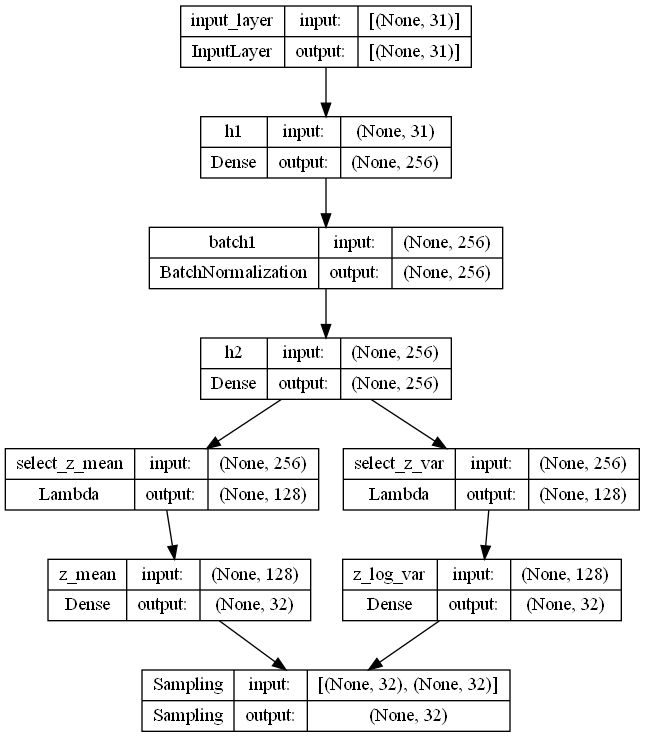

In [6]:
keras.utils.plot_model(encoder, show_shapes=True)

In [7]:
# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
n_x4 = 256
x = Dense(n_x4, activation="relu", name="h4")(latent_inputs)
x = BatchNormalization(name="batch1")(x)
x = Dense(n_x4, activation="relu", name="h5")(x)
cont_decoder_outputs = Dense(30, activation = 'linear', name="cont_decoder_output")(x)
class_decoder_output = Dense(1, activation="sigmoid", name="classification_output")(x)
decoder = keras.Model(latent_inputs, [cont_decoder_outputs, class_decoder_output], name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 h4 (Dense)                     (None, 256)          8448        ['input_1[0][0]']                
                                                                                                  
 batch1 (BatchNormalization)    (None, 256)          1024        ['h4[0][0]']                     
                                                                                                  
 h5 (Dense)                     (None, 256)          65792       ['batch1[0][0]']                 
                                                                                            

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.reconstruction_loss_class_tracker = keras.metrics.Mean(
            name="reconstruction_loss_class"
        )
        self.mean_abs_diff_cont_tracker = keras.metrics.Mean(name='mean_abs_diff_cont')
        self.mean_abs_diff_class_tracker = keras.metrics.Mean(name='mean_abs_diff_class')
        self.mean_binary_tracker = keras.metrics.Mean(name="mean_binary_value")
        self.kl_div_tracker = keras.metrics.Mean(name='kl_divergence')

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.reconstruction_loss_class_tracker,

        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction_cont, reconstruction_class = self.decoder(z)

            data_cont = data[
                :, :30
            ]  
            data_class = data[:, 30:]  # Assuming the last column is for classification

            # Reconstruction loss for continuous outputs
            reconstruction_loss_cont = keras.losses.mean_squared_error(
                data_cont, reconstruction_cont
            )

            # Reconstruction loss for classification output
            reconstruction_loss_class = keras.losses.binary_crossentropy(
                data_class, reconstruction_class
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss, axis=1)

            # Compute the KL Div between original data and reconstructed
            kl_div = tf.keras.losses.KLDivergence()(data_cont, reconstruction_cont)

            # Combine losses
            total_loss = (
                reconstruction_loss_cont + reconstruction_loss_class + 0.0001*kl_loss
            )

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss_cont)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_class_tracker.update_state(reconstruction_loss_class)
        self.kl_div_tracker.update_state(kl_div)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss_cont": self.reconstruction_loss_tracker.result(),
            "reconstruction_loss_class": self.reconstruction_loss_class_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "sparse_categorical_crossentropy": self.reconstruction_loss_class_tracker.result(),
            "kl_div": self.kl_div_tracker.result(),
        }
    
    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]  # Unpack the tuple and take the input data

        data_cont = data[:, :30]  # Assuming the first 4 columns are for continuous variables
        data_class = data[:, 30:]  # Assuming the last column is for classification

        z_mean, z_log_var, z = self.encoder(data)

        reconstruction_cont, reconstruction_class =self.decoder(z)

        reconstruction_loss_cont = keras.losses.mean_squared_error(
            data_cont, reconstruction_cont
        )

        # Reconstruction loss for classification output
        reconstruction_loss_class = keras.losses.binary_crossentropy(
            data_class, reconstruction_class
        )


        kl_loss = -0.5 * (
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )
        kl_loss = tf.reduce_mean(kl_loss, axis=1)

        # Combine losses
        total_loss = (
                reconstruction_loss_cont + reconstruction_loss_class + 0.0001*kl_loss
            )

        # Compute mean absolute differences and mean of binary data
        mean_abs_diff_cont = tf.reduce_mean(tf.abs(data_cont - reconstruction_cont))
        mean_abs_diff_class = tf.reduce_mean(tf.abs(data_class - reconstruction_class))
        mean_binary_value = tf.reduce_mean(tf.cast(reconstruction_class >= 0.5, tf.float32))

        # Compute the KL Div between original data and reconstructed
        kl_div = tf.keras.losses.KLDivergence()(data_cont, reconstruction_cont)

        # Update the loss tracker
        self.total_loss_tracker.update_state(total_loss)

        # Update other metrics
        self.reconstruction_loss_tracker.update_state(reconstruction_loss_cont)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_class_tracker.update_state(reconstruction_loss_class)
        self.mean_abs_diff_cont_tracker.update_state(mean_abs_diff_cont)
        self.mean_abs_diff_class_tracker.update_state(mean_abs_diff_class)
        self.mean_binary_tracker.update_state(mean_binary_value)
        self.kl_div_tracker.update_state(kl_div)

        # Return a dict mapping metric names to current value
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss_cont": self.reconstruction_loss_tracker.result(),
            "reconstruction_loss_class": self.reconstruction_loss_class_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "mean_abs_diff_cont": self.mean_abs_diff_cont_tracker.result(),
            "mean_abs_diff_class": self.mean_abs_diff_class_tracker.result(),
            "mean_binary_value": self.mean_binary_tracker.result(),
            "kl_div": self.kl_div_tracker.result(),
        }

In [9]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [10]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitoring validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore weights to the best model observed during training
)

# Define the directory to save the model
model_dir = "saved_model/"

# Define a TensorBoard callback for training logs
tensorboard_callback = TensorBoard(log_dir="logs/vae_optimized_263")

# # Define a ModelCheckpoint callback to save the model
# checkpoint_callback = ModelCheckpoint(
#     filepath=model_dir, save_best_only=True, monitor="val_loss", mode="min"
# )
#tensorboard_callback
call_back_list = [early_stopping_callback]

hist = vae.fit(
    test_data_array,
    epochs=100,
    batch_size=32,
    validation_data=(val_data_array, None), 
    callbacks=call_back_list,
)

Epoch 1/100
1781/1781 [==============================] - 8s 4ms/step - loss: 0.0257 - reconstruction_loss_cont: 0.0144 - reconstruction_loss_class: 0.0028 - kl_loss: 3.0056 - sparse_categorical_crossentropy: 0.0111 - kl_div: 2.4387 - val_loss: 0.0015 - val_reconstruction_loss_cont: 0.0012 - val_reconstruction_loss_class: 2.3504e-05 - val_kl_loss: 3.3263 - val_mean_abs_diff_cont: 0.0253 - val_mean_abs_diff_class: 2.3478e-05 - val_mean_binary_value: 0.0015 - val_kl_div: 0.2617
Epoch 2/100
1775/1781 [============================>.] - ETA: 0s - loss: 0.0012 - reconstruction_loss_cont: 8.2808e-04 - reconstruction_loss_class: 1.9910e-05 - kl_loss: 3.3385 - sparse_categorical_crossentropy: 2.1917e-05 - kl_div: 0.2106

KeyboardInterrupt: 

# Synth Data Creation

In [ ]:
# synth Data from Data
generated_data_cont_from_data, generated_data_class_from_data = vae.decoder.predict(
    encoder(test_data_array)[2]
)

# synth Data from Data random sample
latent_vectors = np.random.normal(scale=1, size=(50000, latent_dim))
generated_data_cont_from_sample, generated_data_class_from_sample = vae.decoder.predict(latent_vectors)

1563/1563 [==============================] - 2s 1ms/step


Saving the synth data from data

In [ ]:
binary_predictions_from_data = (generated_data_class_from_data >= 0.5).astype(int)
print(sum(binary_predictions_from_data))

# Create DataFrame with synthetic data
synthetic_data_from_data = pd.DataFrame(generated_data_cont_from_data, columns=train_data.columns[:-1])
# Add binary_predictions as an additional column
synthetic_data_from_data["Class"] = binary_predictions_from_data
synthetic_data_from_data.to_csv("../data/interim/synthdata_from_data.csv", index=False)

[92]


Saving the synth data from sample

In [ ]:
binary_predictions_from_sample = (generated_data_class_from_sample >= 0.5).astype(int)
print(sum(binary_predictions_from_sample))

# Create DataFrame with synthetic data
synthetic_data_from_sample = pd.DataFrame(
    generated_data_cont_from_sample, columns=train_data.columns[:-1]
)
# Add binary_predictions as an additional column
synthetic_data_from_sample["Class"] = binary_predictions_from_sample
synthetic_data_from_sample.to_csv("../data/interim/synthdata_from_sample.csv", index=False)

[19424]


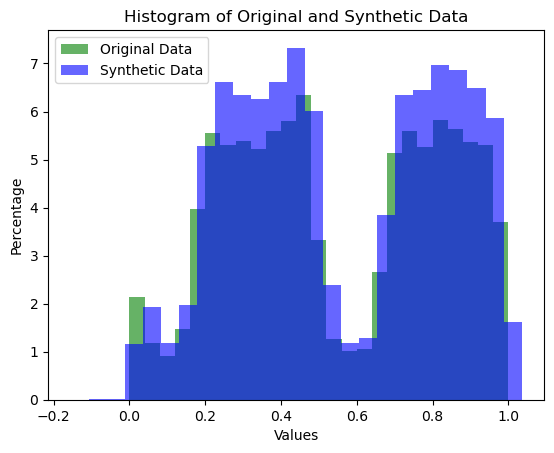

In [ ]:
# Assuming iris_array is the NumPy array you obtained from the Pandas DataFrame
colum_num = 0
original_column = train_data_array[:, colum_num]

synth_column = generated_data_cont_from_data[:, colum_num]

# Calculate the percentage for original_column
total_points_original = len(original_column)
percentage_original = (original_column / total_points_original) * 100

# Calculate the percentage for synth_column
total_points_synth = len(synth_column)
percentage_synth = (synth_column / total_points_synth) * 100

# Plot histograms
plt.hist(
    original_column,
    bins=25,
    color="g",
    alpha=0.6,
    weights=np.ones_like(original_column) / total_points_original * 100,
    label="Original Data",
)

plt.hist(
    synth_column,
    bins=25,
    color="b",
    alpha=0.6,
    weights=np.ones_like(synth_column) / total_points_synth * 100,
    label="Synthetic Data",
)

plt.title("Histogram of Original and Synthetic Data")
plt.xlabel("Values")
plt.ylabel("Percentage")
plt.legend()

plt.show()

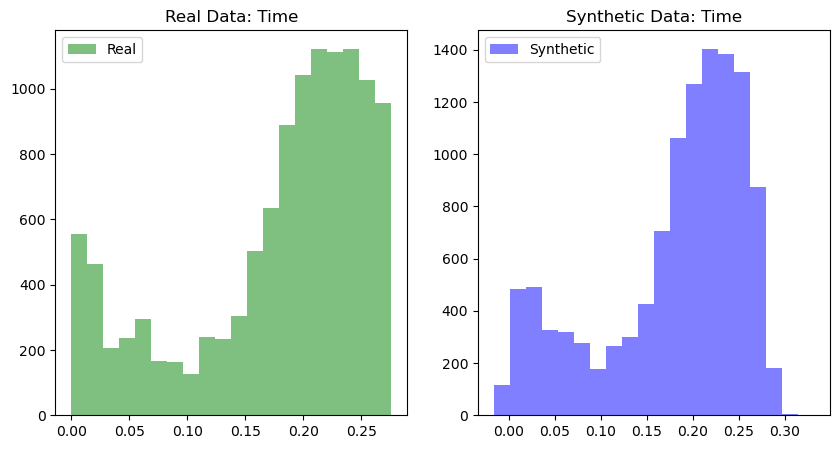

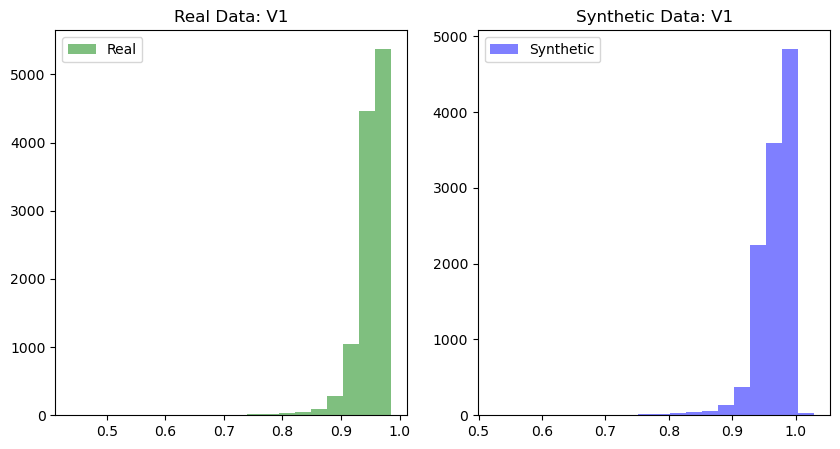

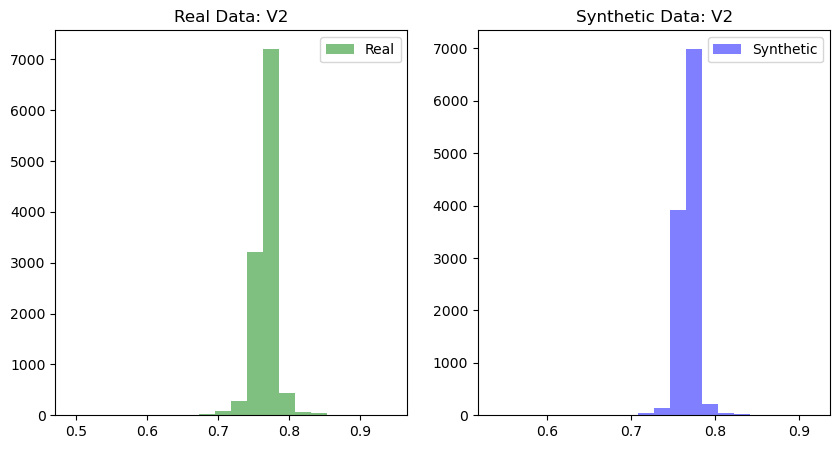

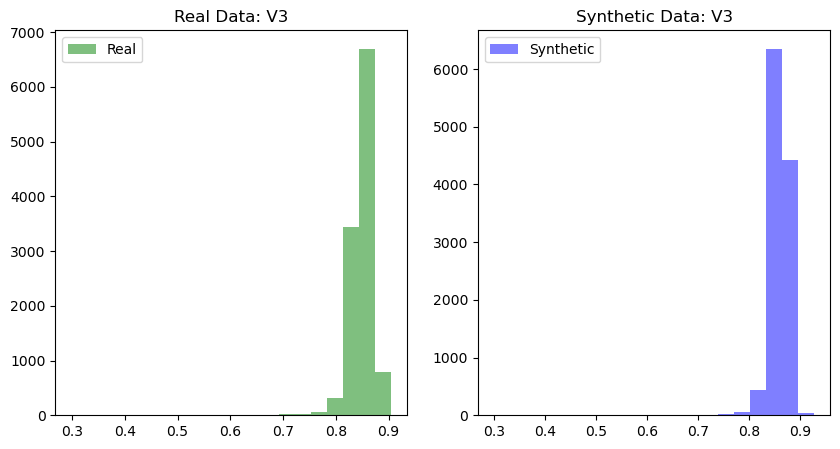

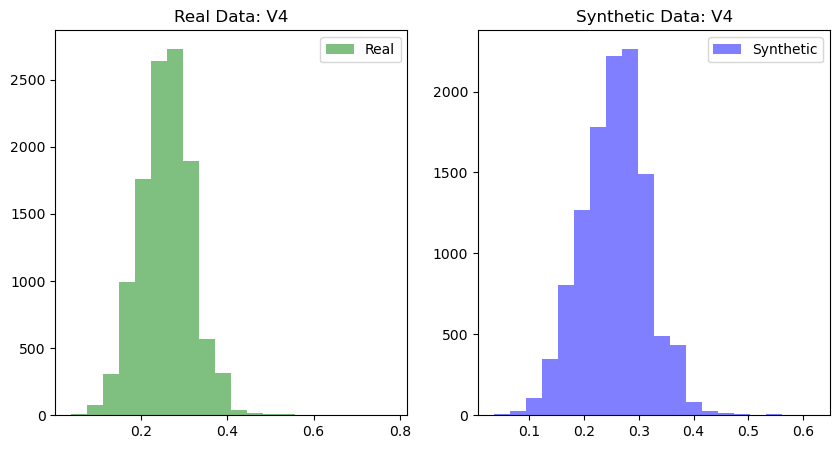

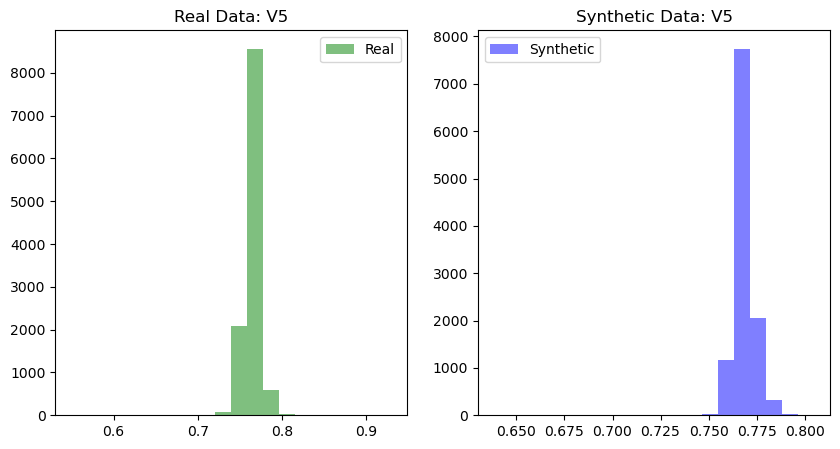

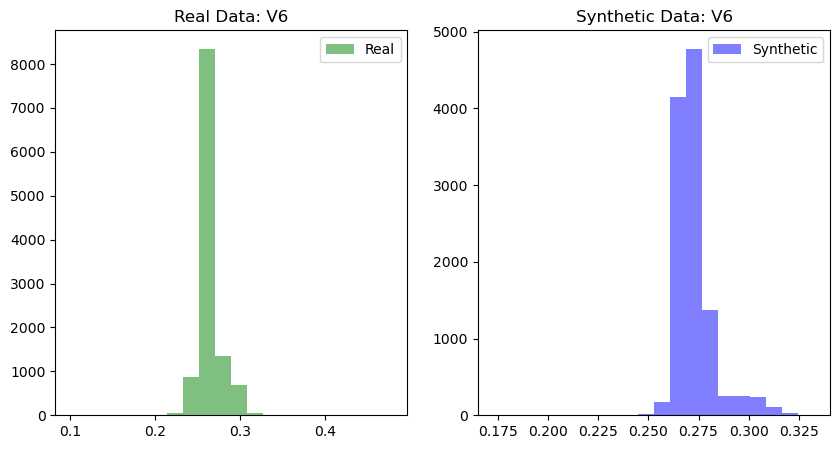

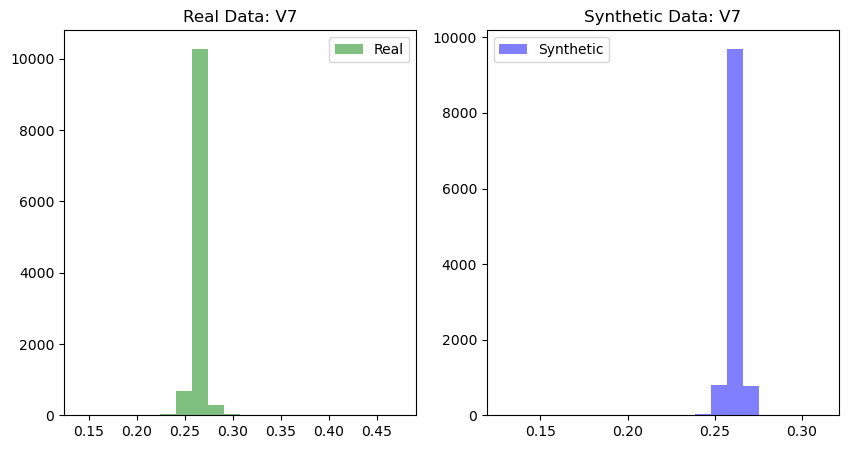

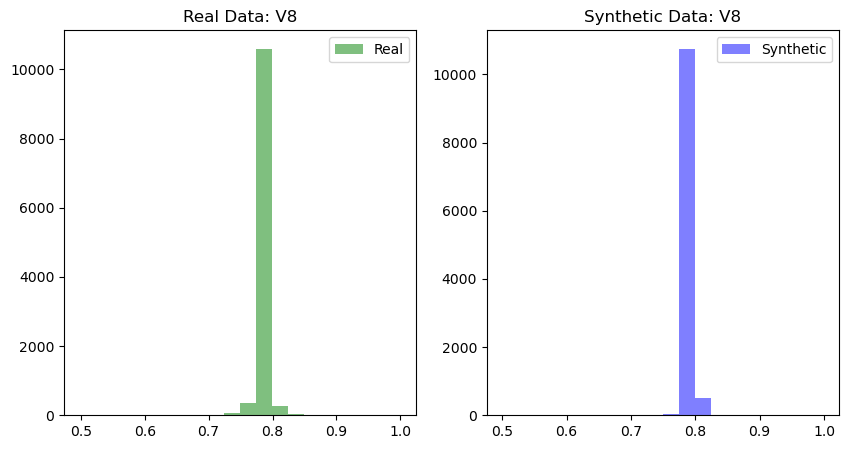

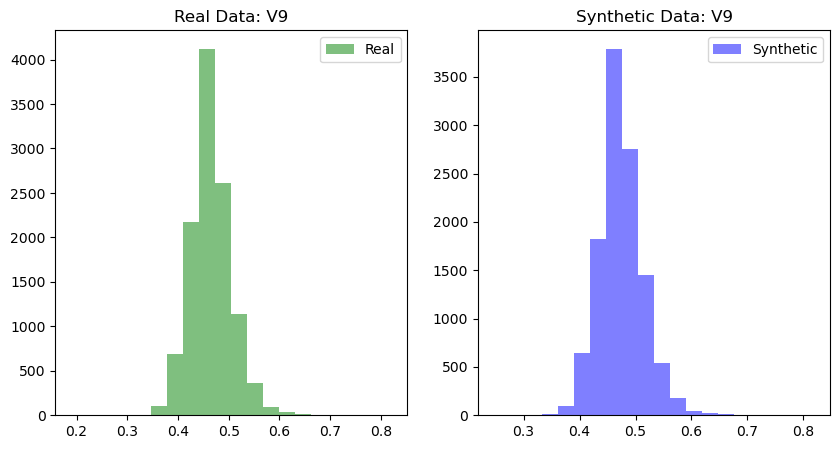

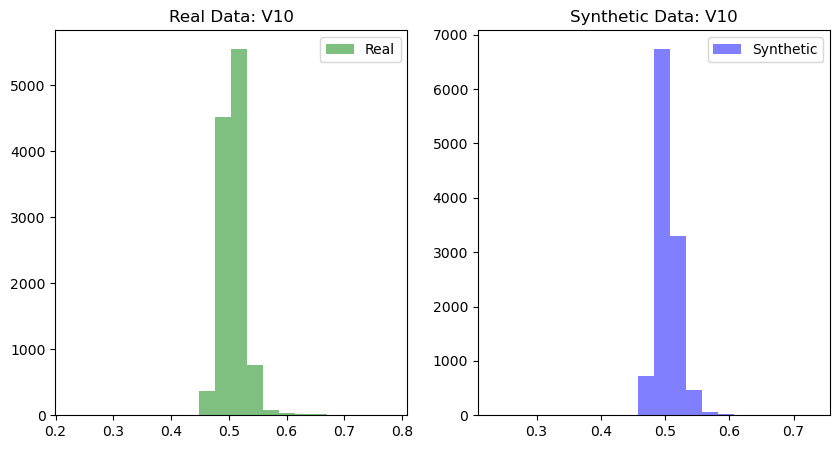

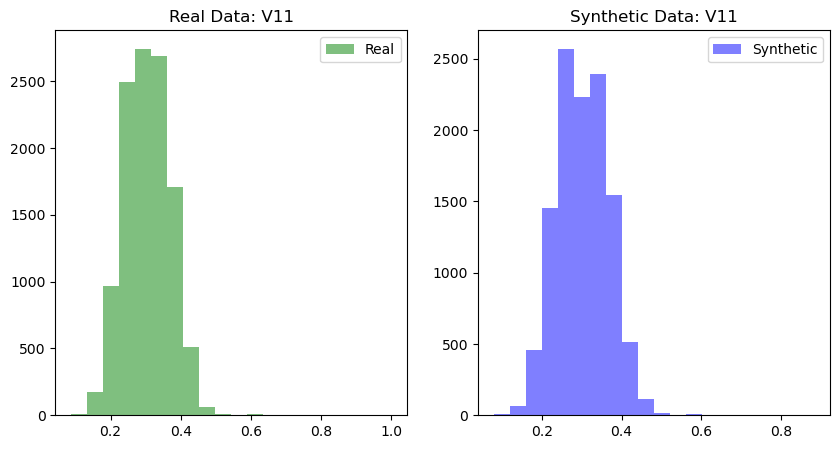

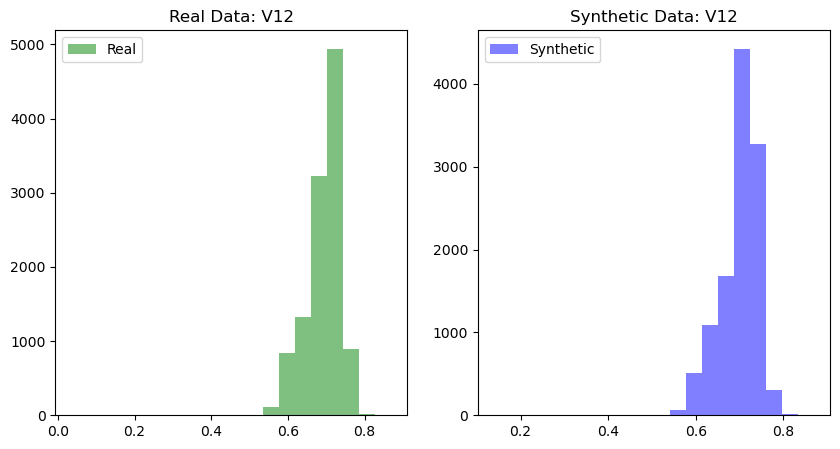

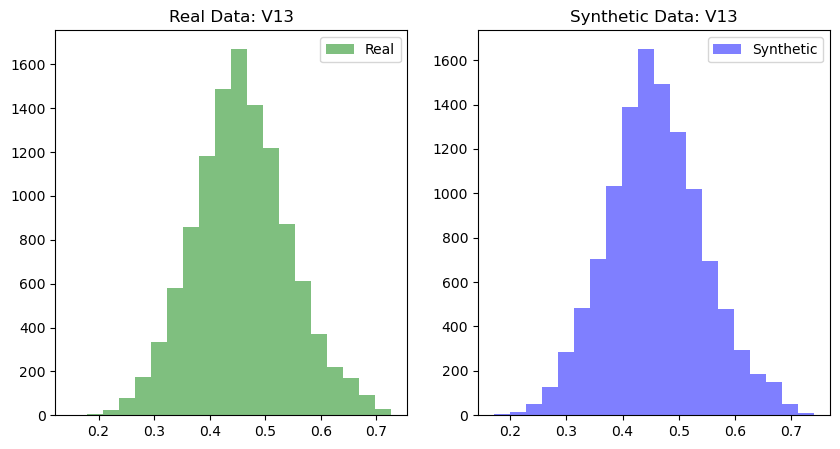

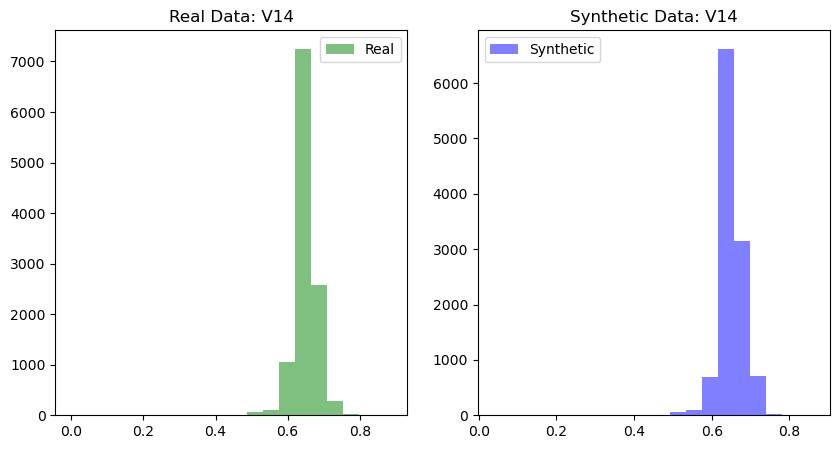

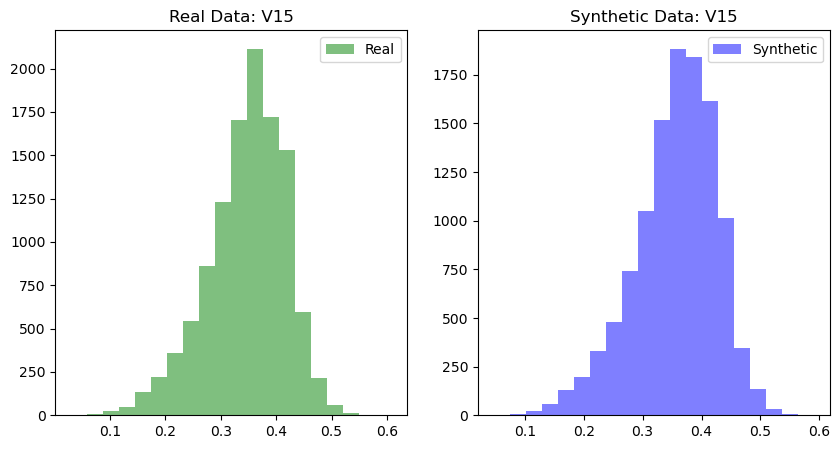

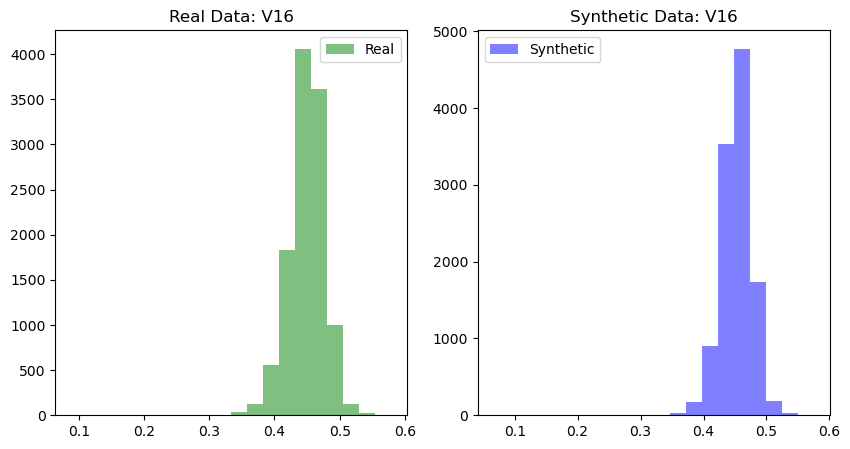

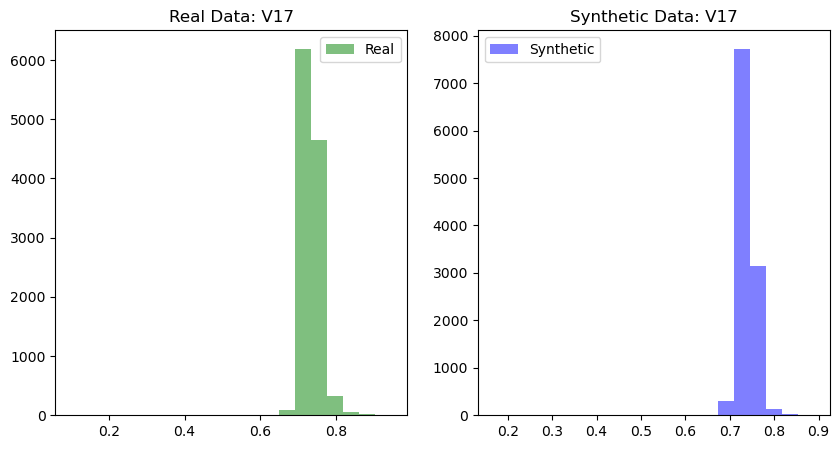

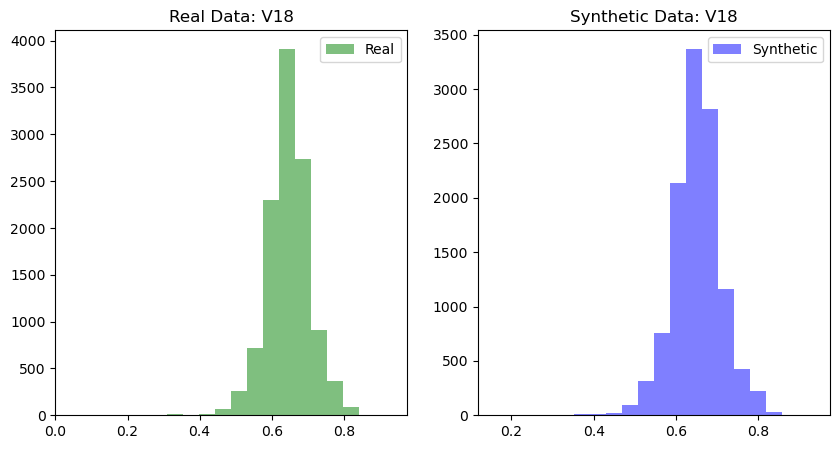

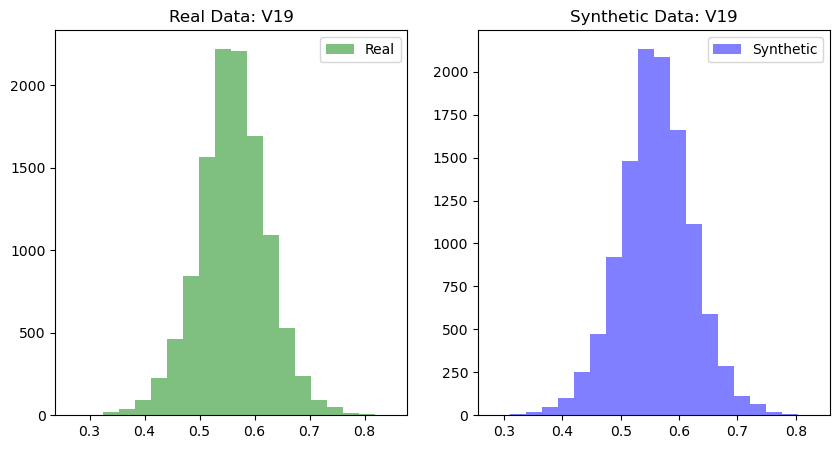

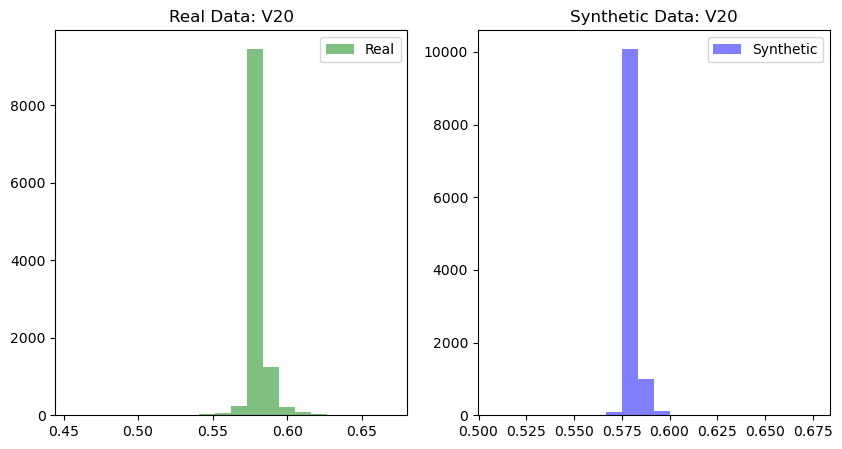

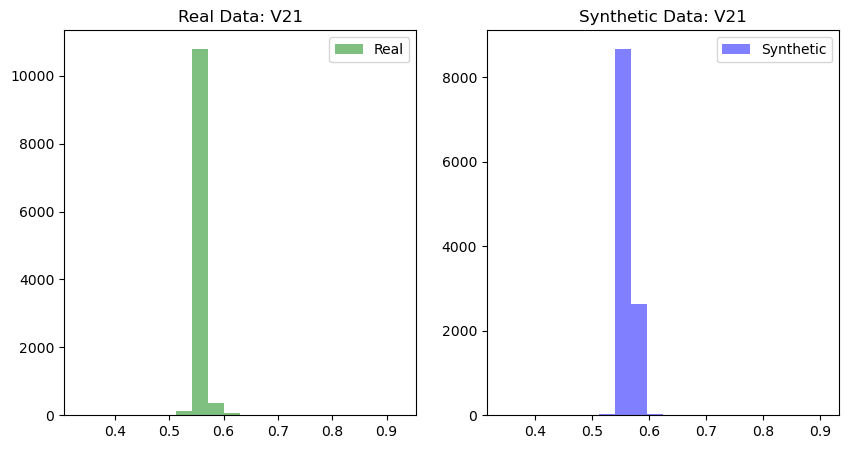

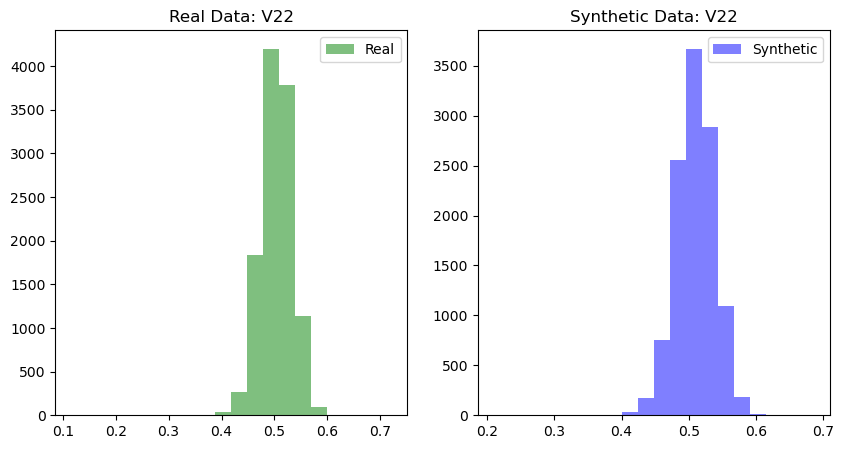

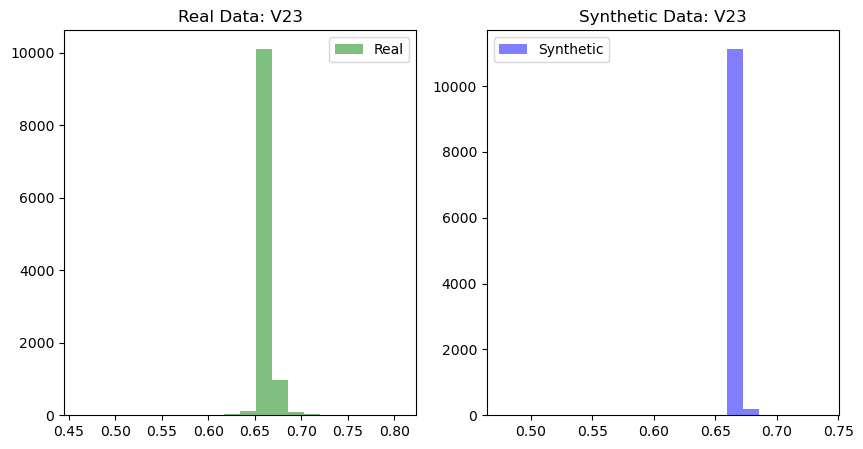

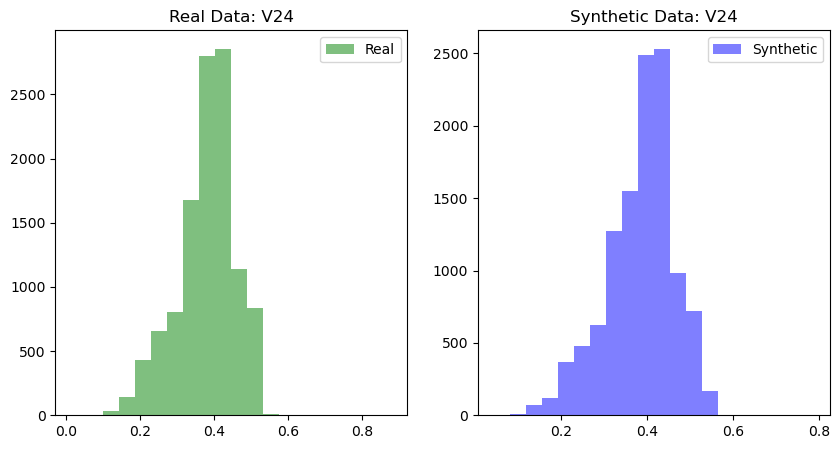

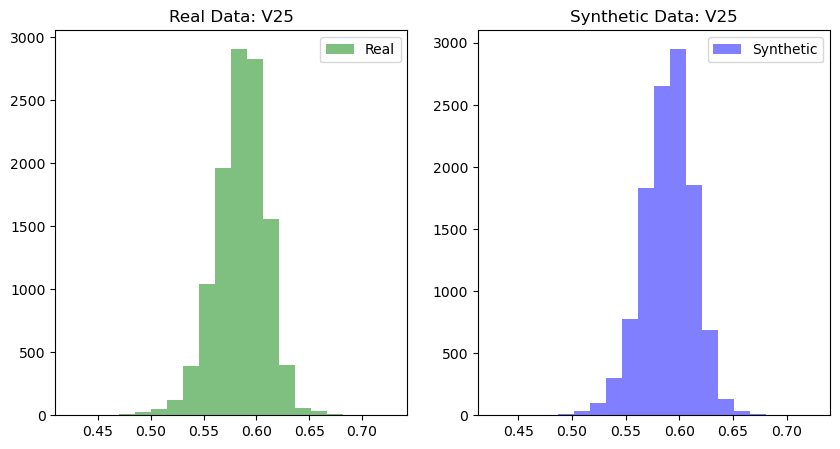

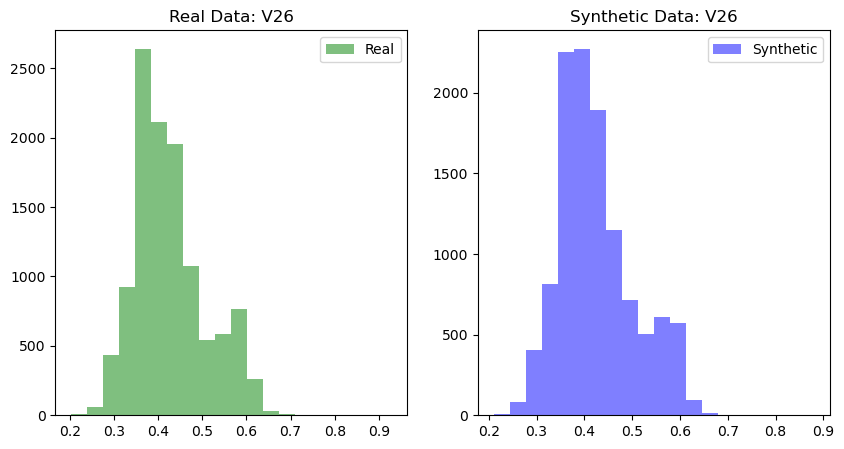

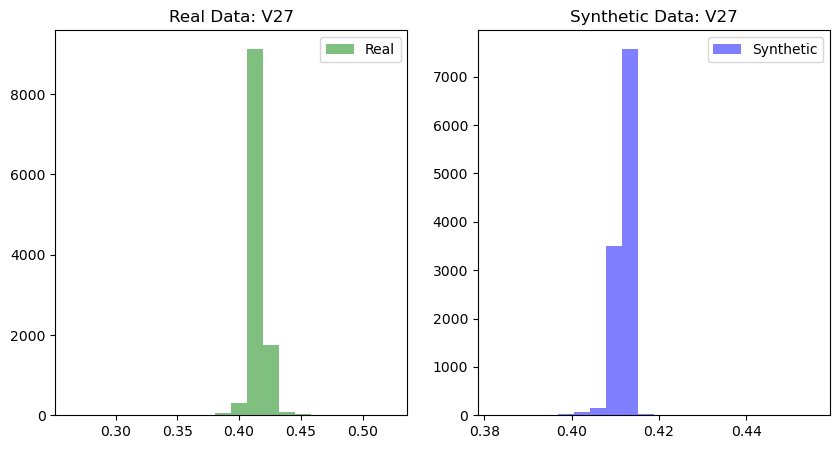

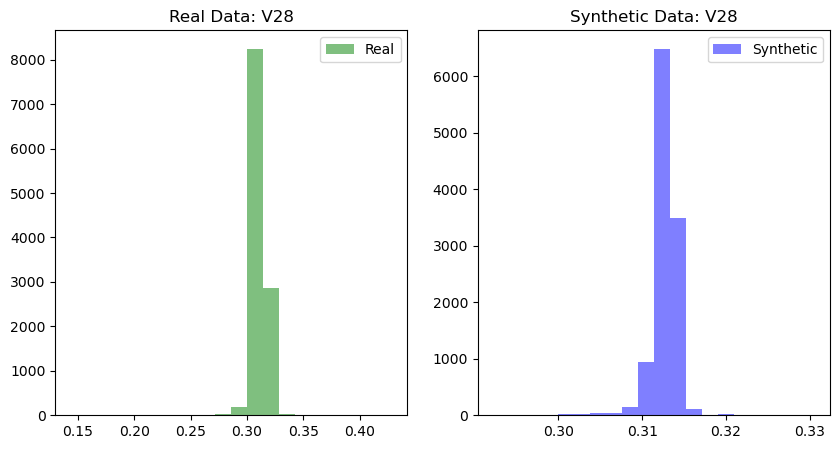

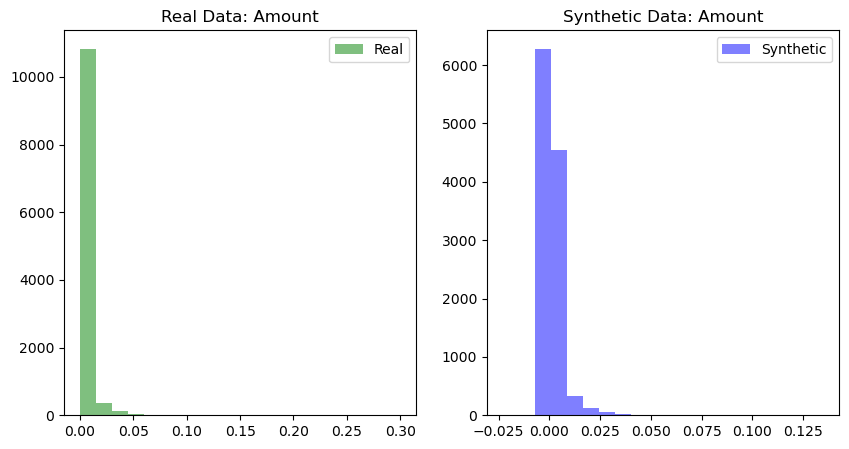

Summary statistics for the real data:
               Time            V1            V2            V3            V4  \
count  11392.000000  11392.000000  11392.000000  11392.000000  11392.000000   
mean       0.179015      0.954303      0.767311      0.849308      0.258770   
std        0.077978      0.030703      0.016229      0.025294      0.061676   
min        0.000000      0.439247      0.493594      0.298431      0.037992   
25%        0.146367      0.941371      0.761330      0.840949      0.219086   
50%        0.201977      0.953840      0.768033      0.850852      0.259526   
75%        0.237747      0.977995      0.775038      0.862039      0.298264   
max        0.276020      0.986102      0.943609      0.905346      0.780667   

                 V5            V6            V7            V8            V9  \
count  11392.000000  11392.000000  11392.000000  11392.000000  11392.000000   
mean       0.764045      0.263939      0.264667      0.785952      0.465356   
std        0.

In [ ]:
# For each feature, create a histogram for the real and synthetic data
for feature in df_credit.columns[:-1]:
    
    
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.hist(real_data[feature], bins=20, alpha=0.5, color="g", label="Real")
    plt.title(f"Real Data: {feature}")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(synthetic_data[feature], bins=20, alpha=0.5, color="b", label="Synthetic")
    plt.title(f"Synthetic Data: {feature}")
    plt.legend()

    plt.show()

# Print the summary statistics for the real and synthetic data
print("Summary statistics for the real data:")
print(real_data.describe())
print("\nSummary statistics for the synthetic data:")
print(synthetic_data.describe())

plt.show()